In [6]:
import warnings
warnings.filterwarnings('ignore')

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Dropout, GlobalAveragePooling2D, MaxPooling2D, Flatten, 
    Conv2D, BatchNormalization, Activation, Input
)
from tensorflow.keras.regularizers import l2


In [28]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [30]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpu_devices))

Num GPUs Available:  1


In [ ]:
# !pip install speedtest-cli
# !speedtest-cli


In [ ]:
# !unzip ./face_populer.zip 

In [18]:
dataset_test = './face_populer/test'
dataset_train = './face_populer/train'

image_size = (48, 48)
batch_size = 64


train_datagen = ImageDataGenerator(
    rescale=1 / 255.0,
    rotation_range = 10,
    zoom_range = 0.1,
    horizontal_flip = True
)

train_generator = train_datagen.flow_from_directory(
    directory=dataset_train,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True,
    seed=42

)

test_datagen = ImageDataGenerator(
    rescale=1 / 255.0,
)

validation_generator = test_datagen.flow_from_directory(
    directory=dataset_test,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode = 'grayscale',
    shuffle=True,
    seed=42
    
    
)


labels = train_generator.class_indices
print(labels)


total_train_images = train_generator.samples
total_val_images = validation_generator.samples
total_images = total_train_images + total_val_images

print("Total training images:", total_train_images)
print("Total validation images:", total_val_images)
print("Total images in dataset:", total_images)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Total training images: 28709
Total validation images: 7178
Total images in dataset: 35887


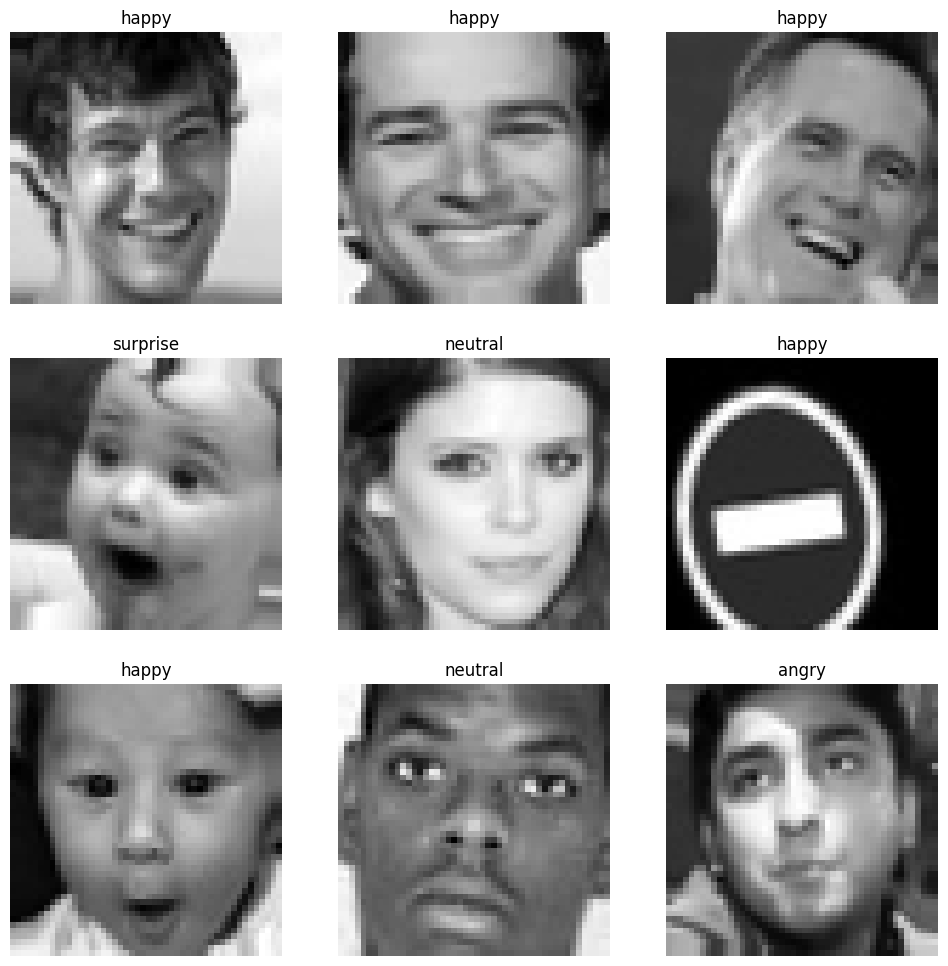

In [3]:
images, labels = train_generator.next()

num_images = 9  

plt.figure(figsize=(12, 12))

class_indices = train_generator.class_indices
class_labels = list(class_indices.keys())

for i in range(num_images):
 
    ax = plt.subplot(3, 3, i + 1)
    
  
    image = images[i]
    image = np.clip(image, 0, 1)  

    plt.imshow(image.squeeze(), cmap='gray')
    
    label_index = np.argmax(labels[i])  
    label_name = class_labels[label_index]  
    
    plt.title(label_name)
    plt.axis("off")

plt.show()


In [24]:
model = tf.keras.models.Sequential()

# Block 1
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))  

# Block 2
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3)) 

# Block 3
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3)) 

# Block 4
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))  

model.add(Flatten())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))  # Regularisasi L2
model.add(BatchNormalization())
model.add(Dropout(0.5))  

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  # Regularisasi L2
model.add(BatchNormalization())
model.add(Dropout(0.5))  

model.add(Dense(7, activation='softmax'))


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_6 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 64)       

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)


Epoch 1/30
359/359 [==============================] - 56s 137ms/step - loss: 6.0434 - accuracy: 0.1912 - val_loss: 3.6125 - val_accuracy: 0.2235 - lr: 0.0010
Epoch 2/30
359/359 [==============================] - 42s 118ms/step - loss: 2.8167 - accuracy: 0.2419 - val_loss: 2.3520 - val_accuracy: 0.2507 - lr: 0.0010
Epoch 3/30
359/359 [==============================] - 41s 115ms/step - loss: 2.0853 - accuracy: 0.2904 - val_loss: 2.1487 - val_accuracy: 0.1899 - lr: 0.0010
Epoch 4/30
359/359 [==============================] - 42s 118ms/step - loss: 1.8530 - accuracy: 0.3592 - val_loss: 2.1555 - val_accuracy: 0.2863 - lr: 0.0010
Epoch 5/30
359/359 [==============================] - 43s 120ms/step - loss: 1.6649 - accuracy: 0.4220 - val_loss: 1.6638 - val_accuracy: 0.4001 - lr: 0.0010
Epoch 6/30
359/359 [==============================] - 44s 123ms/step - loss: 1.5801 - accuracy: 0.4547 - val_loss: 1.5890 - val_accuracy: 0.4490 - lr: 0.0010
Epoch 7/30
359/359 [==============================] 

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
best_model = keras.models.load_model('my_best_model.h5')


Y_pred = best_model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=validation_generator.class_indices.keys()))


23/23 [==============================] - 3s 101ms/step
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.13      0.13       191
     disgust       0.06      0.05      0.05        22
        fear       0.10      0.07      0.08       204
       happy       0.25      0.25      0.25       354
     neutral       0.17      0.20      0.19       246
         sad       0.15      0.16      0.15       249
    surprise       0.08      0.08      0.08       166

    accuracy                           0.16      1432
   macro avg       0.13      0.13      0.13      1432
weighted avg       0.16      0.16      0.16      1432



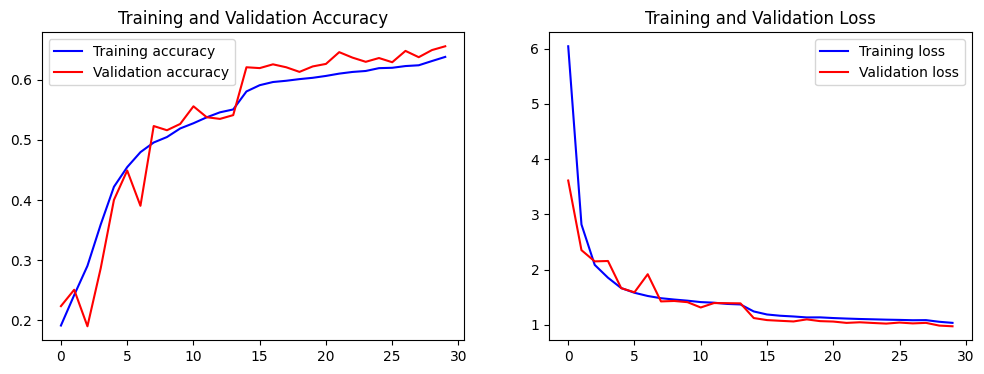

In [27]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()


plot_training_history(history)


In [19]:
from tensorflow.keras.models import Model
def create_model(input_shape = (48,48,1),num_classes=7):

    input = Input(shape=input_shape)
    x = Conv2D(filters=256,kernel_size=3,activation='relu',padding='same')(input)

    x = Conv2D(filters=512,kernel_size=3,activation='relu',padding='same')(x)
    x = BatchNormalization()(x)

    
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.4)(x)

    x = Conv2D(filters=384,kernel_size=3,activation='relu',padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.4)(x)

    x = Conv2D(filters=192,kernel_size=3,activation='relu',padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.4)(x)


    x = Conv2D(filters=384,kernel_size=3,activation='relu',padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.4)(x)

    x = Flatten()(x)

    x = Dense(256,activation='relu')(x)
    x = BatchNormalization()(x)

    x = Dropout(0.3)(x)
    x = Dense(num_classes,activation='softmax')(x)

    return Model(input,x,name='fer_model')


if __name__=='__main__':
    model = create_model()
    model.summary()

Model: "fer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 48, 48, 256)       2560      
                                                                 
 conv2d_26 (Conv2D)          (None, 48, 48, 512)       1180160   
                                                                 
 batch_normalization_25 (Bat  (None, 48, 48, 512)      2048      
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 24, 24, 512)      0         
 g2D)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 24, 24, 512)       0 

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)


Epoch 1/720
449/449 [==============================] - 207s 455ms/step - loss: 1.9941 - accuracy: 0.2547 - val_loss: 1.7839 - val_accuracy: 0.2799 - lr: 0.0010
Epoch 2/720
449/449 [==============================] - 114s 254ms/step - loss: 1.6548 - accuracy: 0.3581 - val_loss: 2.2281 - val_accuracy: 0.2034 - lr: 0.0010
Epoch 3/720
449/449 [==============================] - 114s 253ms/step - loss: 1.4415 - accuracy: 0.4447 - val_loss: 1.4683 - val_accuracy: 0.4211 - lr: 0.0010
Epoch 4/720
449/449 [==============================] - 112s 250ms/step - loss: 1.3268 - accuracy: 0.4942 - val_loss: 1.3096 - val_accuracy: 0.5015 - lr: 0.0010
Epoch 5/720
449/449 [==============================] - 112s 249ms/step - loss: 1.2540 - accuracy: 0.5249 - val_loss: 1.1779 - val_accuracy: 0.5490 - lr: 0.0010
Epoch 6/720
449/449 [==============================] - 111s 247ms/step - loss: 1.2129 - accuracy: 0.5376 - val_loss: 1.1804 - val_accuracy: 0.5447 - lr: 0.0010
Epoch 7/720
449/449 [===================

In [21]:
model.save('model.h5')

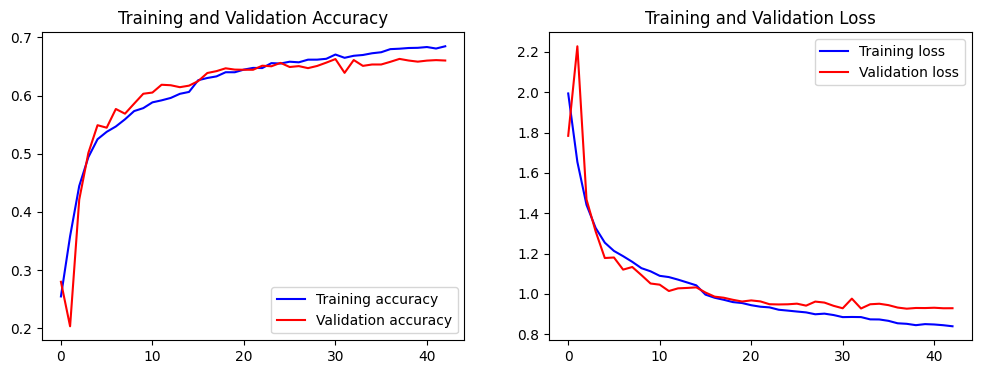

In [22]:
plot_training_history(history)


### Testing pake fine tuning google/vit-base-patch16-224-in21k

In [ ]:
# !pip install tensorflow transformers datasets

In [ ]:
from transformers import TFViTModel, ViTConfig

vit_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model.trainable = False


In [ ]:
from transformers import ViTForImageClassification, ViTFeatureExtractor
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score

# Memuat model dan feature extractor
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=len(labels))
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

# Fungsi untuk preprocessing dan konversi ke tensor
def preprocess_data(generator):
    images, labels = [], []
    for _ in range(len(generator)):
        img_batch, label_batch = generator.next()
        images.append(img_batch)
        labels.append(label_batch)
    return tf.convert_to_tensor(np.vstack(images)), tf.convert_to_tensor(np.vstack(labels))

# Mendapatkan data pelatihan dan validasi
train_images, train_labels = preprocess_data(train_generator)
val_images, val_labels = preprocess_data(validation_generator)

# Mengubah ukuran gambar dan normalisasi
train_images = tf.image.resize(train_images, (224, 224))  # ViT mengharuskan input 224x224
val_images = tf.image.resize(val_images, (224, 224))

# Melatih model
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(batch_size),
    eval_dataset=tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(batch_size)
)

# Mulai training
trainer.train()

# Evaluasi model
predictions = trainer.predict(tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(batch_size))
val_preds = tf.argmax(predictions.predictions, axis=1).numpy()
val_labels = tf.argmax(val_labels, axis=1).numpy()
accuracy = accuracy_score(val_labels, val_preds)

print(f"Validation Accuracy: {accuracy:.4f}")
